In [1]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install -U scikit-learn
# !pip install xgboost
# !pip install lightgbm

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("float_format", "{:.4f}".format)
sns.set_style("whitegrid")

In [3]:
RANDOM_STATE = 42

# Data Definition

In [4]:
_data = load_diabetes()

print(_data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
data = _data["data"]
feature_names = _data["feature_names"]

df = pd.DataFrame(data, columns=feature_names)
df["target"] = _data["target"]

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0381,0.0507,0.0617,0.0219,-0.0442,-0.0348,-0.0434,-0.0026,0.0199,-0.0176,151.0000
1,-0.0019,-0.0446,-0.0515,-0.0263,-0.0084,-0.0192,0.0744,-0.0395,-0.0683,-0.0922,75.0000
2,0.0853,0.0507,0.0445,-0.0057,-0.0456,-0.0342,-0.0324,-0.0026,0.0029,-0.0259,141.0000
3,-0.0891,-0.0446,-0.0116,-0.0367,0.0122,0.0250,-0.0360,0.0343,0.0227,-0.0094,206.0000
4,0.0054,-0.0446,-0.0364,0.0219,0.0039,0.0156,0.0081,-0.0026,-0.0320,-0.0466,135.0000


# EDA

## Correlation

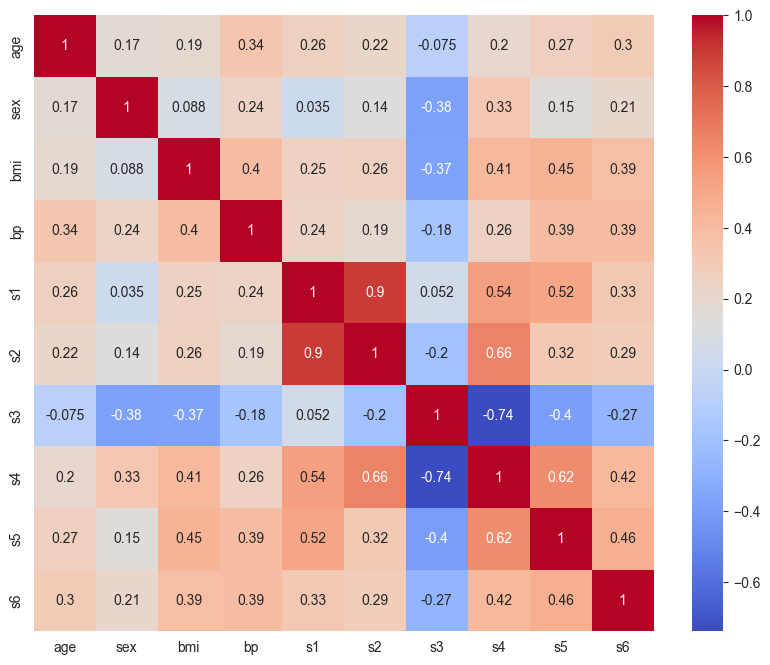

In [6]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    data=df.drop("target", axis=1).corr(),
    annot=True,
    cmap="coolwarm",
)

plt.show()

# Machine Learning Regression

## Decision Tree

[Reference] https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

### Dataset Definition

In [7]:
X = df.drop("target", axis=1)
y = df["target"]

# 먼저 train+valid와 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# train+valid를 다시 train과 valid로 분할 (75:25)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

In [8]:
print(f"데이터 분할 결과:")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Valid: {len(X_valid)} ({len(X_valid)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

데이터 분할 결과:
Train: 264 (59.7%)
Valid: 89 (20.1%)
Test: 89 (20.1%)


### Model (Vanilla)

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [10]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [11]:
model.score(X_train, y_train)

1.0

In [12]:
print(model.intercept_, model.coef_)

AttributeError: 'DecisionTreeRegressor' object has no attribute 'intercept_'

#### Feature Importance

In [13]:
model.feature_importances_

array([0.08981708, 0.00592253, 0.43861624, 0.08517564, 0.04463861,
       0.04418316, 0.05650334, 0.05949104, 0.13289137, 0.04276099])

In [14]:
feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [15]:
_feature_importances = pd.Series(
    model.feature_importances_,
    index=feature_names,
)

_feature_importances

age   0.0898
sex   0.0059
bmi   0.4386
bp    0.0852
s1    0.0446
s2    0.0442
s3    0.0565
s4    0.0595
s5    0.1329
s6    0.0428
dtype: float64

<Axes: >

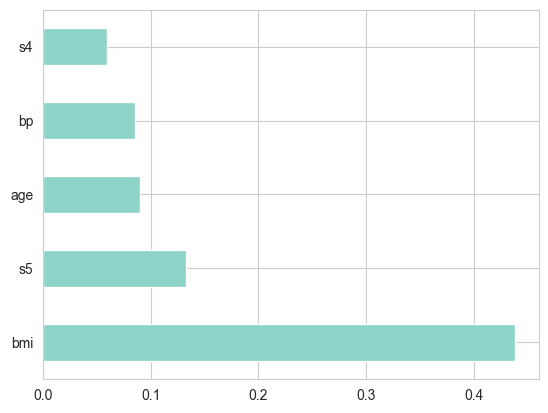

In [16]:
_feature_importances.nlargest().plot(kind="barh")

#### Prediction

In [17]:
# 각 셋에 대한 예측
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

In [18]:
# 각 셋의 성능 평가
def calculate_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {
        'Set': set_name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

In [19]:
# 모든 셋의 성능 계산
train_metrics = calculate_metrics(y_train, y_train_pred, 'Train')
valid_metrics = calculate_metrics(y_valid, y_valid_pred, 'Valid')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame([train_metrics, valid_metrics, test_metrics])
results_df = results_df.set_index('Set')

print("=== Train/Valid/Test 셋 성능 비교 ===")
print(results_df.round(4))

=== Train/Valid/Test 셋 성능 비교 ===
           R²       MSE    RMSE   MAPE
Set                                   
Train  1.0000    0.0000  0.0000 0.0000
Valid  0.2095 4330.7978 65.8088 0.3744
Test  -0.2659 6706.9101 81.8957 0.5430


#### Metrics

In [20]:
# 과적합 분석
print(f"\n=== 과적합 분석 ===")
train_valid_r2_diff = train_metrics['R²'] - valid_metrics['R²']
valid_test_r2_diff = valid_metrics['R²'] - test_metrics['R²']

print(f"Train-Valid R² 차이: {train_valid_r2_diff:.4f}")
print(f"Valid-Test R² 차이: {valid_test_r2_diff:.4f}")


=== 과적합 분석 ===
Train-Valid R² 차이: 0.7905
Valid-Test R² 차이: 0.4754


- 임계값 0.1 
    - 아래 코드에서 0.1로 비교하는 것은 고정 규칙이 아니라 경험적 가이드 입니다 
    - 모델/데이터별 차이가 있어 동일 기준으로 일관되게 적용할 수 없습니다 
    - 해당 파일에서는 우선적으로 경험적 가이드를 적용하여 진행합니다 
    
- 객관적 판단을 위해서는 "데이터 기반 임계값" 통한 비교 필요 => (모델 최적화 과정에서 확인) 
    - k-fold에서 val R^2의 표준편차 σ_val을 구해
    - 과적합 : (train_mean - val_mean) > max(0.05, 2*σ_val)
    - 일반화 문제 : |test - val_mean| > 2*σ_val

In [21]:
if train_valid_r2_diff > 0.1:
    print("⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 과적합 위험 낮음: 훈련 데이터와 검증 데이터 간 성능이 유사합니다.")

if valid_test_r2_diff > 0.1:
    print("⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 일반화 성능 양호: 검증 데이터와 테스트 데이터 간 성능이 유사합니다.")

⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.
⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.


In [22]:
# 모델 설명력 해석
print(f"\n=== 모델 설명력 해석 ===")
print(f"훈련 데이터 R²: {train_metrics['R²']:.4f} ({train_metrics['R²']*100:.2f}%)")
print(f"검증 데이터 R²: {valid_metrics['R²']:.4f} ({valid_metrics['R²']*100:.2f}%)")
print(f"테스트 데이터 R²: {test_metrics['R²']:.4f} ({test_metrics['R²']*100:.2f}%)")
print(f"→ 최종 테스트에서 모델이 {test_metrics['R²']*100:.1f}%의 분산을 설명합니다.")


=== 모델 설명력 해석 ===
훈련 데이터 R²: 1.0000 (100.00%)
검증 데이터 R²: 0.2095 (20.95%)
테스트 데이터 R²: -0.2659 (-26.59%)
→ 최종 테스트에서 모델이 -26.6%의 분산을 설명합니다.


In [23]:
# 오차 정확도 해석
print(f"\n=== 오차 정확도 해석 ===")
print(f"Train RMSE: {train_metrics['RMSE']:.2f}")
print(f"Valid RMSE: {valid_metrics['RMSE']:.2f}")
print(f"Test RMSE: {test_metrics['RMSE']:.2f}")
print(f"Test MAPE: {test_metrics['MAPE']:.4f} ({test_metrics['MAPE']*100:.2f}%)")
print(f"→ 최종 테스트에서 예측값이 실제값에 대해 평균적으로 ±{test_metrics['MAPE']*100:.1f}% 정도의 오차를 보입니다.")


=== 오차 정확도 해석 ===
Train RMSE: 0.00
Valid RMSE: 65.81
Test RMSE: 81.90
Test MAPE: 0.5430 (54.30%)
→ 최종 테스트에서 예측값이 실제값에 대해 평균적으로 ±54.3% 정도의 오차를 보입니다.


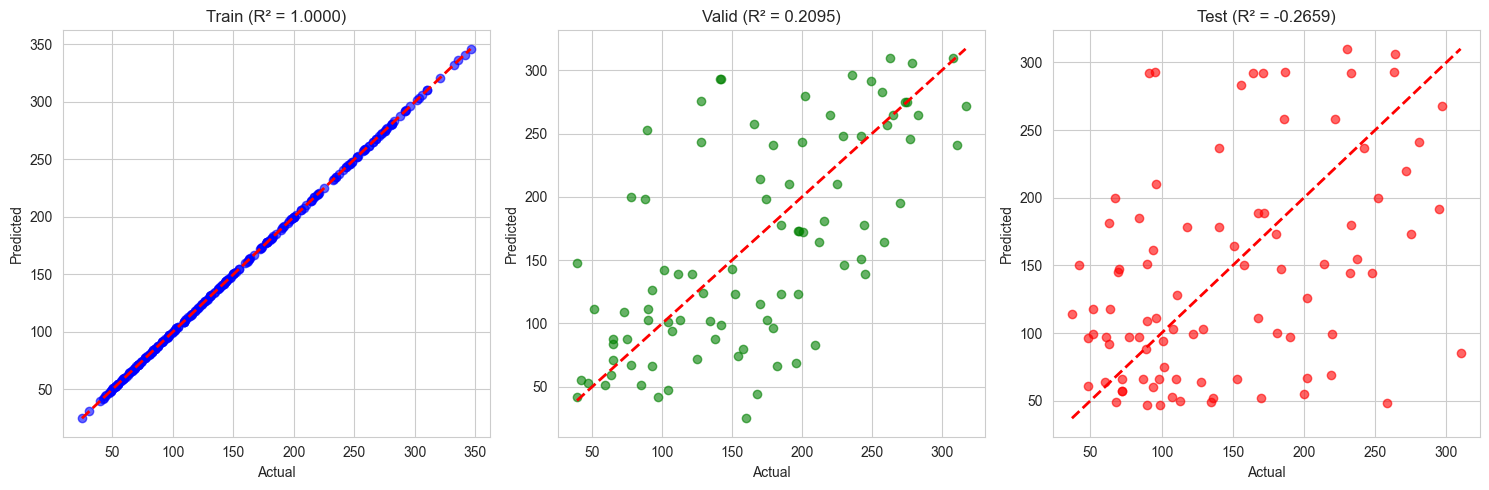

In [24]:
# 시각화: 실제값 vs 예측값 비교
plt.figure(figsize=(15, 5))

# 훈련 데이터
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color="blue")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Train (R² = {train_metrics['R²']:.4f})")

# 검증 데이터
plt.subplot(1, 3, 2)
plt.scatter(y_valid, y_valid_pred, alpha=0.6, color="green")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Valid (R² = {valid_metrics['R²']:.4f})")

# 테스트 데이터
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.6, color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test (R² = {test_metrics['R²']:.4f})")

plt.tight_layout()
plt.show()

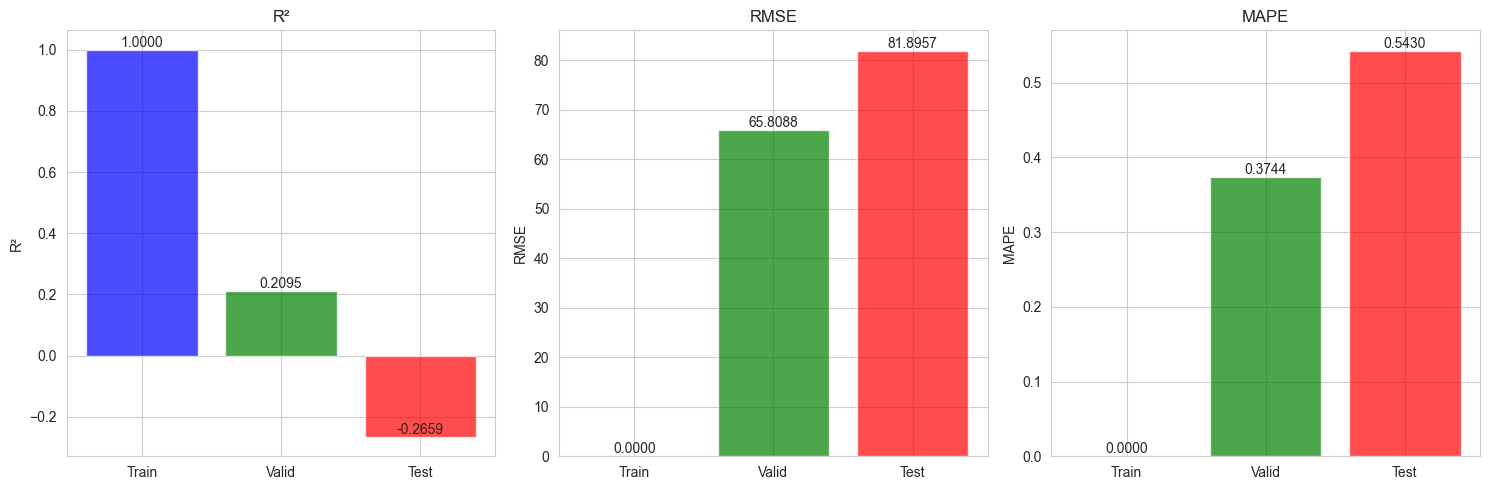

In [25]:
# 성능 지표 비교 차트
metrics_to_plot = ['R²', 'RMSE', 'MAPE']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics_to_plot):
    values = [train_metrics[metric], valid_metrics[metric], test_metrics[metric]]
    sets = ['Train', 'Valid', 'Test']
    
    bars = axes[i].bar(sets, values, color=['blue', 'green', 'red'], alpha=0.7)
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    
    # 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

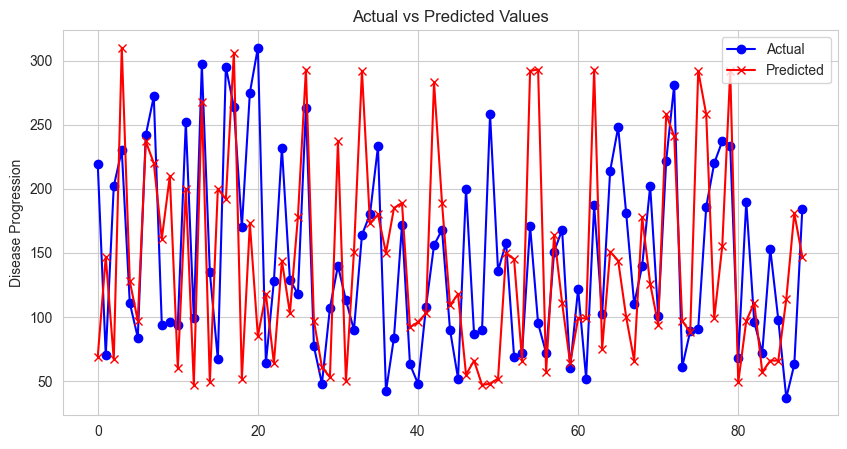

In [26]:
# actual vs predicted
plt.figure(figsize=(10, 5))

plt.plot(y_test.values, label="Actual", marker="o", color="blue")
plt.plot(y_test_pred, label="Predicted", marker="x", color="red")

plt.title("Actual vs Predicted Values")
plt.ylabel("Disease Progression")
plt.legend()
plt.show()

#### Tree Structure

In [27]:
from sklearn.tree import plot_tree

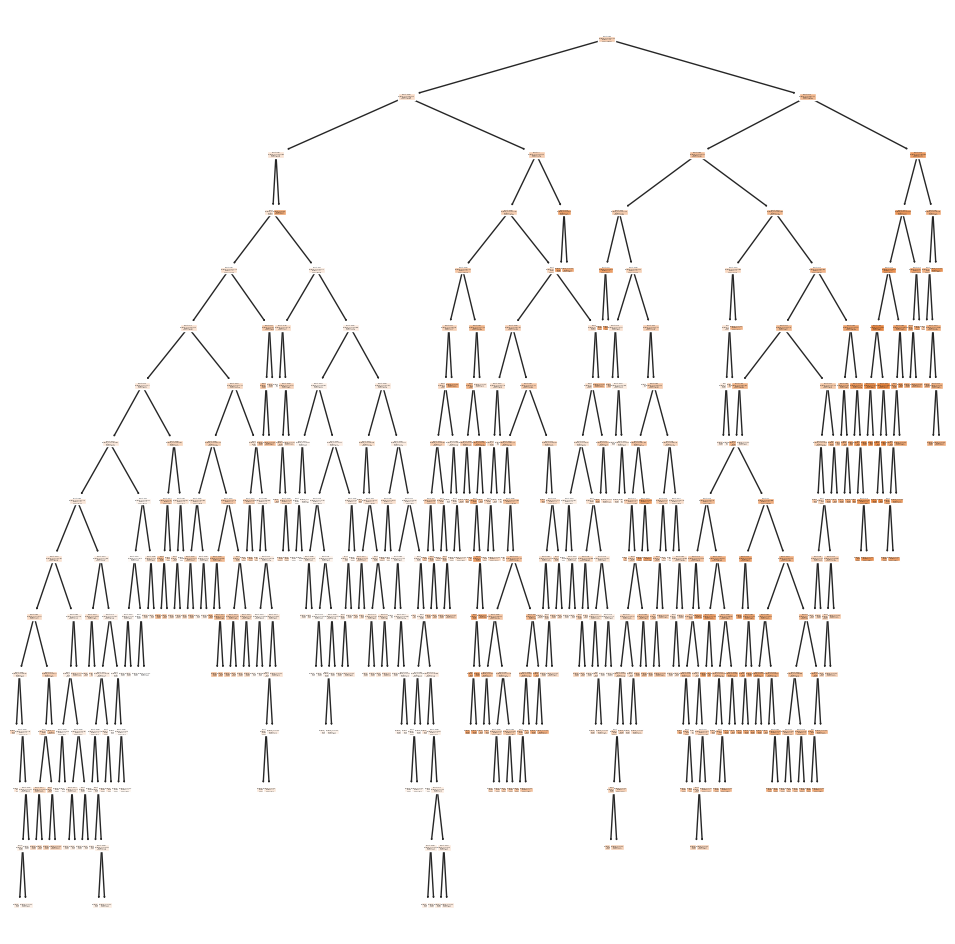

In [28]:
plt.figure(figsize=(12, 12))
plot_tree(model, filled=True)
plt.show()

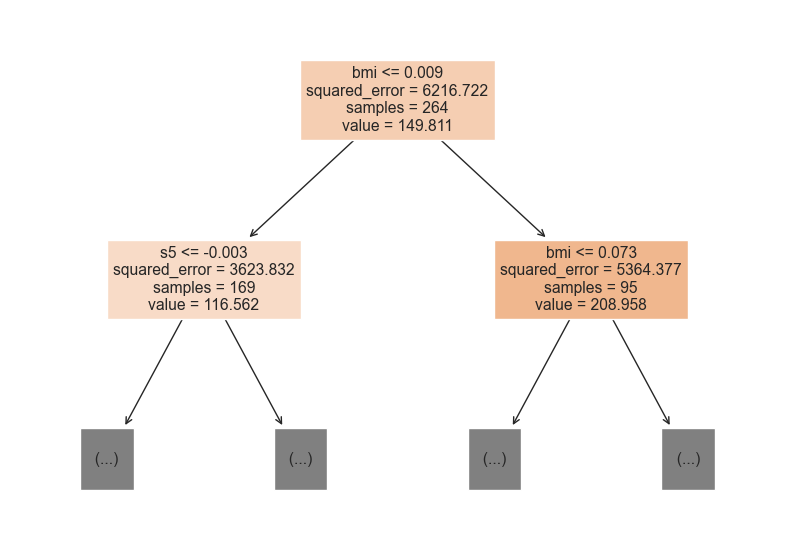

In [29]:
plt.figure(figsize=(10, 7))

plot_tree(
    model,
    filled=True,
    max_depth=1,
    feature_names=feature_names,
)

plt.show()

### Retraining (feat.Prunning)

In [30]:
models = {
    "DecisionTree": DecisionTreeRegressor(
        max_depth=3,          # 트리의 최대 깊이
        min_samples_split=5,  # 노트 분할 시, 최소한 5개의 샘플이 있어야 함
        min_samples_leaf=5,   # 리프 노드에는 최소한 5개의 샘플리 있어야 함
        random_state=RANDOM_STATE,
    )
}

In [31]:
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [32]:
model.score(X_train, y_train)

1.0

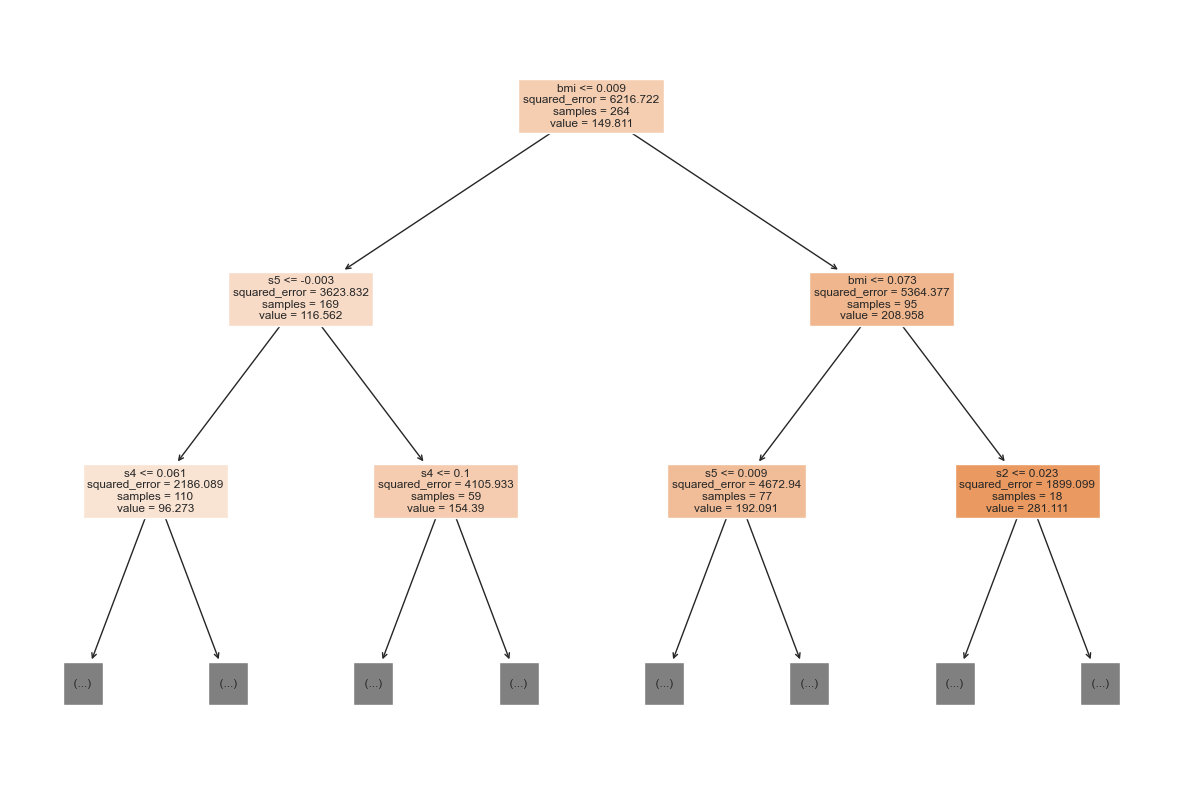

In [33]:
plt.figure(figsize=(15, 10))

plot_tree(
    model,
    filled=True,
    max_depth=2,  # 시각화 위해 제한
    feature_names=feature_names,
)

plt.show()

#### Feature Importance

In [34]:
_feature_importances = pd.Series(
    model.feature_importances_,
    index=feature_names,
)

_feature_importances

age   0.0898
sex   0.0059
bmi   0.4386
bp    0.0852
s1    0.0446
s2    0.0442
s3    0.0565
s4    0.0595
s5    0.1329
s6    0.0428
dtype: float64

<Axes: >

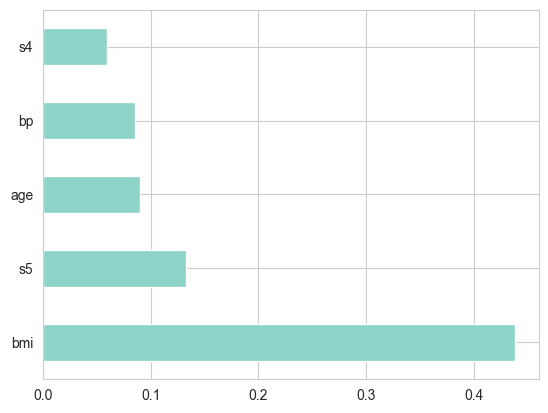

In [35]:
_feature_importances.nlargest().plot(kind="barh")

#### Prediction

In [36]:
# 각 셋에 대한 예측
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

In [37]:
# 모든 셋의 성능 계산
train_metrics = calculate_metrics(y_train, y_train_pred, 'Train')
valid_metrics = calculate_metrics(y_valid, y_valid_pred, 'Valid')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame([train_metrics, valid_metrics, test_metrics])
results_df = results_df.set_index('Set')

print("=== Train/Valid/Test 셋 성능 비교 ===")
print(results_df.round(4))

=== Train/Valid/Test 셋 성능 비교 ===
           R²       MSE    RMSE   MAPE
Set                                   
Train  1.0000    0.0000  0.0000 0.0000
Valid  0.2095 4330.7978 65.8088 0.3744
Test  -0.2659 6706.9101 81.8957 0.5430


In [38]:
# 과적합 분석
print(f"\n=== 과적합 분석 ===")
train_valid_r2_diff = train_metrics['R²'] - valid_metrics['R²']
valid_test_r2_diff = valid_metrics['R²'] - test_metrics['R²']

print(f"Train-Valid R² 차이: {train_valid_r2_diff:.4f}")
print(f"Valid-Test R² 차이: {valid_test_r2_diff:.4f}")

if train_valid_r2_diff > 0.1:
    print("⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 과적합 위험 낮음: 훈련 데이터와 검증 데이터 간 성능이 유사합니다.")

if valid_test_r2_diff > 0.1:
    print("⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 일반화 성능 양호: 검증 데이터와 테스트 데이터 간 성능이 유사합니다.")


=== 과적합 분석 ===
Train-Valid R² 차이: 0.7905
Valid-Test R² 차이: 0.4754
⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.
⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.


## 여러 알고리즘 결과 확인

(대상) Decision Tree, randomForest, Lasso, Ridge, XGB, LGBM

1. 위 알고리즘 중 가장 최적의 예측 성능을 보이는 알고리즘 확인 
    - 현재 단계에서는 cross validation은 고려하지 않음  
2. 최적의 성능을 보이는 알고리즘의 feature importance 확인 
3. 최적의 모델에 대해서만 예측 성능 확인 (RMSE)

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Models

In [40]:
models = {
    "DecisionTree": DecisionTreeRegressor(
        max_depth=4,              # 트리 최대 깊이 제한으로 과적합 방지
        min_samples_split=10,     # 노드 분할 시 최소 10개 샘플 필요
        min_samples_leaf=5,       # 리프 노드에는 최소 5개 샘플 필요
        random_state=RANDOM_STATE,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=100,         # 100개의 의사결정 트리로 앙상블 구성
        max_depth=8,              # 개별 트리 최대 깊이 
        min_samples_split=5,      # 노드 분할 시 최소 5개 샘플 필요
        min_samples_leaf=2,       # 리프 노드에는 최소 2개 샘플 필요
        random_state=RANDOM_STATE,
    ),
    "Lasso": Lasso(
        alpha=0.01,               # 정규화 강도 (작을수록 덜 정규화)
        random_state=RANDOM_STATE,
    ),
    "Ridge": Ridge(
        alpha=0.1,                # 정규화 강도 (작을수록 덜 정규화)
        random_state=RANDOM_STATE,
    ),
    "XGBRegressor": XGBRegressor(
        n_estimators=100,         # 100개의 부스팅 라운드
        max_depth=6,              # 트리 최대 깊이
        learning_rate=0.1,        # 학습률 (작을수록 안정적이지만 느림)
        subsample=0.8,            # 샘플링 비율 (과적합 방지)
        colsample_bytree=0.8,     # 특성 샘플링 비율 (과적합 방지) 
        random_state=RANDOM_STATE,
    ),
    "LGBMRegressor": LGBMRegressor(
        n_estimators=100,         # 100개의 부스팅 라운드
        max_depth=6,              # 트리 최대 깊이
        learning_rate=0.1,        # 학습률
        subsample=0.8,            # 샘플링 비율
        colsample_bytree=0.8,     # 특성 샘플링 비율
        random_state=RANDOM_STATE,
        force_col_wise=True,      # 경고 메시지 방지
    ),
}

In [41]:
# 모든 모델의 성능을 train, valid, test 셋에서 평가
results = {}

for name, model in models.items():
    print(f"\n=== {name} 모델 평가 ===")
    
    # 모델 훈련
    model.fit(X_train, y_train)
    
    # 각 셋에 대한 예측
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
    
    # 각 셋의 성능 계산
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # R² 점수 계산
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 결과 저장 (테스트 성능을 기준으로 최고 모델 선택)
    results[name] = {
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'test_r2': test_r2
    }
    
    # 성능 출력
    print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
    print(f"Valid RMSE: {valid_rmse:.2f}, R²: {valid_r2:.4f}")
    print(f"Test  RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")
    
    # 과적합 여부 확인
    train_valid_diff = train_r2 - valid_r2
    valid_test_diff = valid_r2 - test_r2
    
    if train_valid_diff > 0.1:
        print(f"⚠️  과적합 경고: Train-Valid R² 차이 = {train_valid_diff:.4f}")
    else:
        print(f"✅ 과적합 위험 낮음: Train-Valid R² 차이 = {train_valid_diff:.4f}")
        
    if valid_test_diff > 0.1:
        print(f"⚠️  일반화 문제: Valid-Test R² 차이 = {valid_test_diff:.4f}")
    else:
        print(f"✅ 일반화 성능 양호: Valid-Test R² 차이 = {valid_test_diff:.4f}")


=== DecisionTree 모델 평가 ===
Train RMSE: 49.01, R²: 0.6137
Valid RMSE: 61.05, R²: 0.3196
Test  RMSE: 60.41, R²: 0.3113
⚠️  과적합 경고: Train-Valid R² 차이 = 0.2940
✅ 일반화 성능 양호: Valid-Test R² 차이 = 0.0084

=== RandomForest 모델 평가 ===
Train RMSE: 30.11, R²: 0.8542
Valid RMSE: 54.32, R²: 0.4615
Test  RMSE: 54.87, R²: 0.4318
⚠️  과적합 경고: Train-Valid R² 차이 = 0.3927
✅ 일반화 성능 양호: Valid-Test R² 차이 = 0.0297

=== Lasso 모델 평가 ===
Train RMSE: 54.71, R²: 0.5185
Valid RMSE: 51.13, R²: 0.5229
Test  RMSE: 53.91, R²: 0.4514
✅ 과적합 위험 낮음: Train-Valid R² 차이 = -0.0044
✅ 일반화 성능 양호: Valid-Test R² 차이 = 0.0714

=== Ridge 모델 평가 ===
Train RMSE: 55.16, R²: 0.5105
Valid RMSE: 51.27, R²: 0.5201
Test  RMSE: 53.69, R²: 0.4558
✅ 과적합 위험 낮음: Train-Valid R² 차이 = -0.0096
✅ 일반화 성능 양호: Valid-Test R² 차이 = 0.0643

=== XGBRegressor 모델 평가 ===
Train RMSE: 3.74, R²: 0.9978
Valid RMSE: 55.72, R²: 0.4334
Test  RMSE: 57.27, R²: 0.3810
⚠️  과적합 경고: Train-Valid R² 차이 = 0.5643
✅ 일반화 성능 양호: Valid-Test R² 차이 = 0.0524

=== LGBMRegressor 모델 평가 ===
[L

### Metrics

In [42]:
# 모든 모델의 성능을 비교하는 요약 테이블 생성
print("\n" + "="*80)
print("모든 모델 성능 비교 요약")
print("="*80)

# RMSE 비교 테이블
rmse_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_RMSE': [results[name]['train_rmse'] for name in results.keys()],
    'Valid_RMSE': [results[name]['valid_rmse'] for name in results.keys()],
    'Test_RMSE': [results[name]['test_rmse'] for name in results.keys()],
    'Train_R²': [results[name]['train_r2'] for name in results.keys()],
    'Valid_R²': [results[name]['valid_r2'] for name in results.keys()],
    'Test_R²': [results[name]['test_r2'] for name in results.keys()]
})

# 테스트 성능 기준으로 정렬
rmse_df = rmse_df.sort_values('Test_RMSE')

print("\n=== RMSE 성능 비교 (낮을수록 좋음) ===")
print(rmse_df[['Model', 'Train_RMSE', 'Valid_RMSE', 'Test_RMSE']].round(2))

print("\n=== R² 성능 비교 (높을수록 좋음) ===")
print(rmse_df[['Model', 'Train_R²', 'Valid_R²', 'Test_R²']].round(4))

# 과적합 분석
print("\n=== 과적합 분석 ===")
rmse_df['Train_Valid_R²_Diff'] = rmse_df['Train_R²'] - rmse_df['Valid_R²']
rmse_df['Valid_Test_R²_Diff'] = rmse_df['Valid_R²'] - rmse_df['Test_R²']

for _, row in rmse_df.iterrows():
    model_name = row['Model']
    train_valid_diff = row['Train_Valid_R²_Diff']
    valid_test_diff = row['Valid_Test_R²_Diff']
    
    print(f"{model_name}:")
    if train_valid_diff > 0.1:
        print(f"  ⚠️  과적합 가능성 (Train-Valid R² 차이: {train_valid_diff:.4f})")
    else:
        print(f"  ✅ 과적합 위험 낮음 (Train-Valid R² 차이: {train_valid_diff:.4f})")
        
    if valid_test_diff > 0.1:
        print(f"  ⚠️  일반화 문제 (Valid-Test R² 차이: {valid_test_diff:.4f})")
    else:
        print(f"  ✅ 일반화 성능 양호 (Valid-Test R² 차이: {valid_test_diff:.4f})")
    print()


모든 모델 성능 비교 요약

=== RMSE 성능 비교 (낮을수록 좋음) ===
           Model  Train_RMSE  Valid_RMSE  Test_RMSE
3          Ridge     55.1600     51.2700    53.6900
2          Lasso     54.7100     51.1300    53.9100
1   RandomForest     30.1100     54.3200    54.8700
5  LGBMRegressor     26.2800     57.4000    55.5900
4   XGBRegressor      3.7400     55.7200    57.2700
0   DecisionTree     49.0100     61.0500    60.4100

=== R² 성능 비교 (높을수록 좋음) ===
           Model  Train_R²  Valid_R²  Test_R²
3          Ridge    0.5105    0.5201   0.4558
2          Lasso    0.5185    0.5229   0.4514
1   RandomForest    0.8542    0.4615   0.4318
5  LGBMRegressor    0.8889    0.3987   0.4168
4   XGBRegressor    0.9978    0.4334   0.3810
0   DecisionTree    0.6137    0.3196   0.3113

=== 과적합 분석 ===
Ridge:
  ✅ 과적합 위험 낮음 (Train-Valid R² 차이: -0.0096)
  ✅ 일반화 성능 양호 (Valid-Test R² 차이: 0.0643)

Lasso:
  ✅ 과적합 위험 낮음 (Train-Valid R² 차이: -0.0044)
  ✅ 일반화 성능 양호 (Valid-Test R² 차이: 0.0714)

RandomForest:
  ⚠️  과적합 가능성 (Train-Valid

### Best Model

In [43]:
# 테스트 성능 기준으로 최고 모델 선택
best_model_name = min(results, key=lambda x: results[x]['test_rmse'])
best_model_instance = models[best_model_name]

print(f"=== 최고 성능 모델 분석 ===")
print(f"Best Model: {best_model_name}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.2f}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f} ({results[best_model_name]['test_r2']*100:.2f}%)")


=== 최고 성능 모델 분석 ===
Best Model: Ridge
Test RMSE: 53.69
Test R²: 0.4558 (45.58%)


In [44]:
# 다른 모델들과의 성능 비교
print(f"\n=== 다른 모델들과의 성능 비교 ===")
print("Test RMSE 기준 순위:")
sorted_models = sorted(results.items(), key=lambda x: x[1]['test_rmse'])
for i, (model_name, performance) in enumerate(sorted_models, 1):
    if model_name == best_model_name:
        print(f"{i}. {model_name}: {performance['test_rmse']:.2f} 🏆")
    else:
        print(f"{i}. {model_name}: {performance['test_rmse']:.2f}")


=== 다른 모델들과의 성능 비교 ===
Test RMSE 기준 순위:
1. Ridge: 53.69 🏆
2. Lasso: 53.91
3. RandomForest: 54.87
4. LGBMRegressor: 55.59
5. XGBRegressor: 57.27
6. DecisionTree: 60.41


### Feature Importance

In [45]:
if hasattr(best_model_instance, "feature_importances_"):
    feature_importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": feature_importances}
    )
    feature_importance_df = feature_importance_df.sort_values(
        by="Importance", ascending=False
    )

    print("Feature Importance:")
    print(feature_importance_df)

elif hasattr(best_model_instance, "coef_"):
    coefficients = best_model_instance.coef_
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
    coef_df = coef_df.sort_values(by="Coefficient", key=abs, ascending=False)

    print("=== Coefficients (Feature Importance):")
    print(coef_df)

else:
    print(f"Feature importance is not available.")

=== Coefficients (Feature Importance):
  Feature  Coefficient
2     bmi     486.3793
8      s5     403.8977
3      bp     281.9268
1     sex    -201.4770
6      s3    -185.6912
7      s4     161.8174
5      s2    -125.0469
9      s6     111.1299
4      s1    -103.1486
0     age      39.9838


### Prediction

In [46]:
# Best Model로 예측 수행
y_train_pred = best_model_instance.predict(X_train)
y_valid_pred = best_model_instance.predict(X_valid)
y_test_pred = best_model_instance.predict(X_test)

In [47]:
# 종합 성능 지표 계산 함수
def calculate_comprehensive_metrics(y_true, y_pred, set_name):
    """모든 성능 지표를 계산하는 함수"""
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {
        'Set': set_name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

In [48]:
# 모든 셋의 종합 성능 계산
train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, 'Train')
valid_metrics = calculate_comprehensive_metrics(y_valid, y_valid_pred, 'Valid')
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, 'Test')

# 결과 종합 정리
final_results_df = pd.DataFrame([train_metrics, valid_metrics, test_metrics])
final_results_df = final_results_df.set_index('Set')

print(f"{best_model_name} 최종 성능 평가")
print("="*50)
print(final_results_df.round(4))

Ridge 최종 성능 평가
          R²       MSE    RMSE   MAPE
Set                                  
Train 0.5105 3042.8483 55.1620 0.4105
Valid 0.5201 2629.0688 51.2744 0.3042
Test  0.4558 2883.0570 53.6941 0.3663


In [49]:
# 성능 해석
print(f"\n=== 성능 해석 ===")
print(f"최고 모델: {best_model_name}")
print(f"최종 테스트 성능:")
print(f"   • R² (설명력): {test_metrics['R²']:.4f} ({test_metrics['R²']*100:.2f}%)")
print(f"   • RMSE (오차): {test_metrics['RMSE']:.2f}")
print(f"   • MAPE (상대오차): {test_metrics['MAPE']:.4f} ({test_metrics['MAPE']*100:.2f}%)")


=== 성능 해석 ===
최고 모델: Ridge
최종 테스트 성능:
   • R² (설명력): 0.4558 (45.58%)
   • RMSE (오차): 53.69
   • MAPE (상대오차): 0.3663 (36.63%)


### Metrics

In [50]:
# 과적합 분석
train_valid_r2_diff = train_metrics['R²'] - valid_metrics['R²']
valid_test_r2_diff = valid_metrics['R²'] - test_metrics['R²']

print(f"\n=== 모델 안정성 분석 ===")
if train_valid_r2_diff > 0.1:
    print(f"⚠️  과적합 경고: Train-Valid R² 차이 = {train_valid_r2_diff:.4f}")
else:
    print(f"✅ 과적합 위험 낮음: Train-Valid R² 차이 = {train_valid_r2_diff:.4f}")

if valid_test_r2_diff > 0.1:
    print(f"⚠️  일반화 문제: Valid-Test R² 차이 = {valid_test_r2_diff:.4f}")
else:
    print(f"✅ 일반화 성능 양호: Valid-Test R² 차이 = {valid_test_r2_diff:.4f}")


=== 모델 안정성 분석 ===
✅ 과적합 위험 낮음: Train-Valid R² 차이 = -0.0096
✅ 일반화 성능 양호: Valid-Test R² 차이 = 0.0643


In [51]:
# 성능 지표별 해석
print(f"\n=== 성능 지표별 해석 ===")
print(f"R² (결정계수): {test_metrics['R²']*100:.1f}%의 분산을 설명")
print(f"RMSE: 예측값이 실제값에서 평균 ±{test_metrics['RMSE']:.1f} 단위 오차")
print(f"MAPE: 예측값이 실제값에 대해 평균 ±{test_metrics['MAPE']*100:.1f}% 오차")


=== 성능 지표별 해석 ===
R² (결정계수): 45.6%의 분산을 설명
RMSE: 예측값이 실제값에서 평균 ±53.7 단위 오차
MAPE: 예측값이 실제값에 대해 평균 ±36.6% 오차


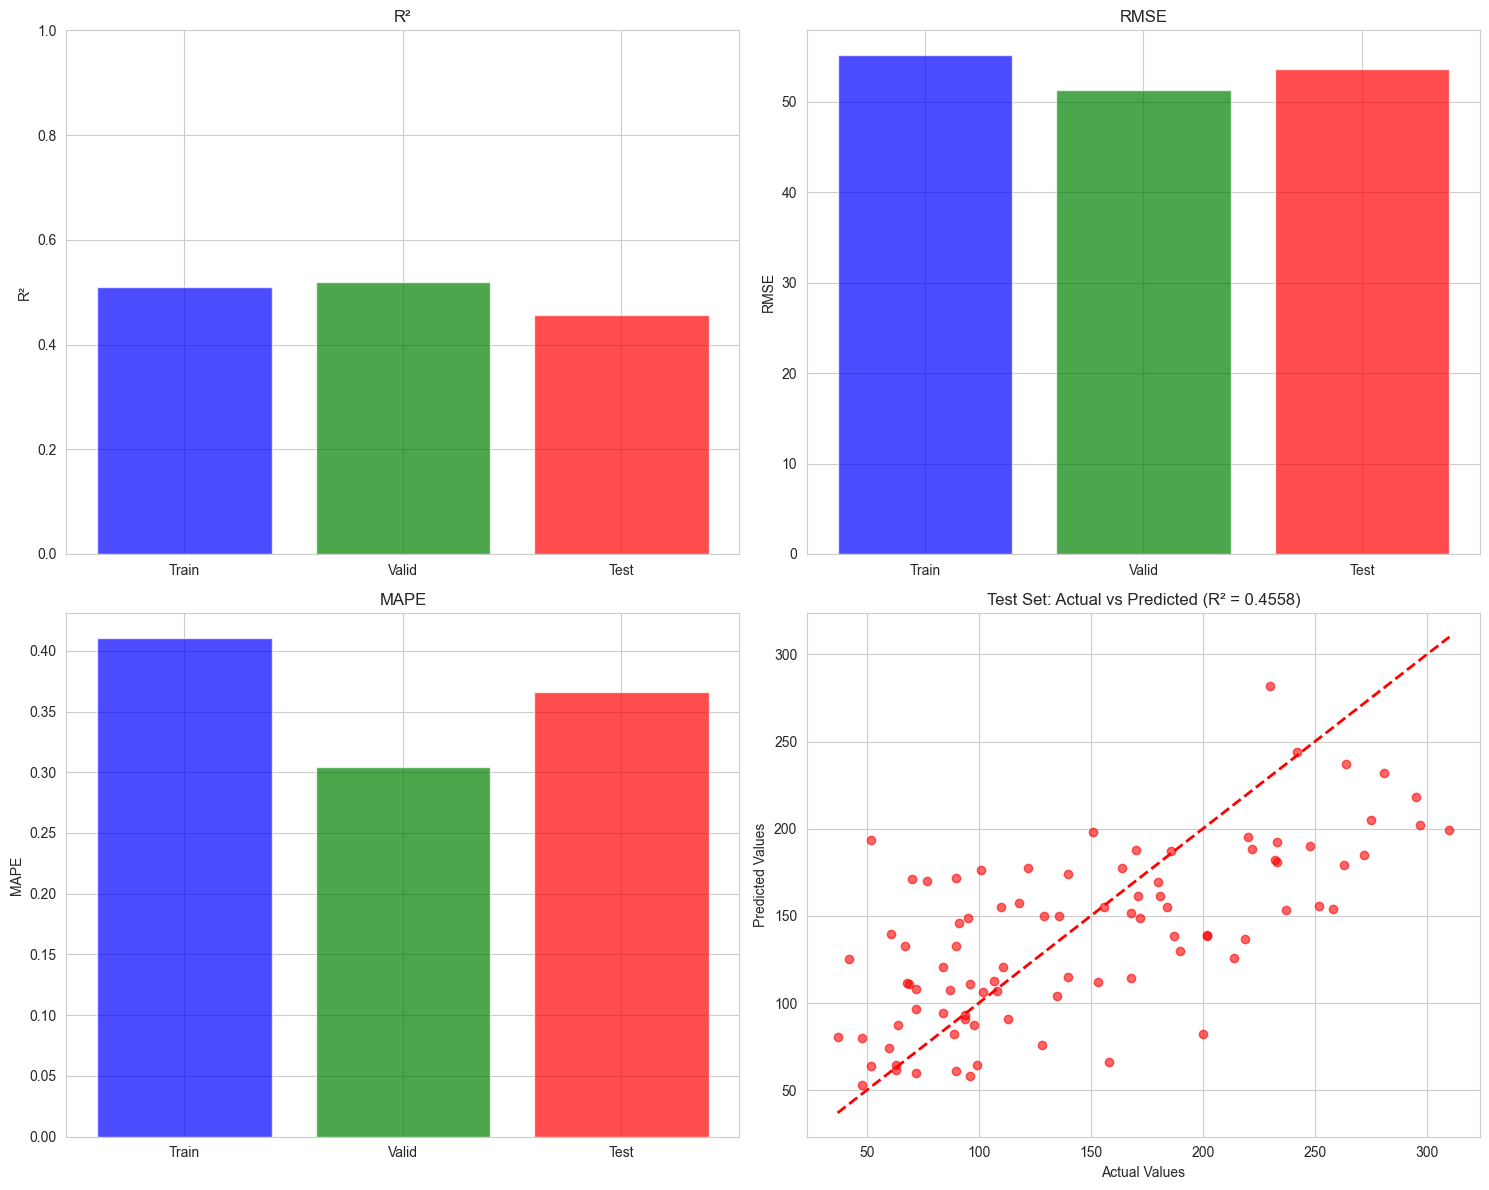

In [52]:
# 성능 지표 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. R² 비교
axes[0, 0].bar(['Train', 'Valid', 'Test'], 
               [train_metrics['R²'], valid_metrics['R²'], test_metrics['R²']],
               color=['blue', 'green', 'red'], alpha=0.7)
axes[0, 0].set_title('R²')
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_ylim(0, 1)

# 2. RMSE 비교
axes[0, 1].bar(['Train', 'Valid', 'Test'], 
               [train_metrics['RMSE'], valid_metrics['RMSE'], test_metrics['RMSE']],
               color=['blue', 'green', 'red'], alpha=0.7)
axes[0, 1].set_title('RMSE')
axes[0, 1].set_ylabel('RMSE')

# 3. MAPE 비교
axes[1, 0].bar(['Train', 'Valid', 'Test'], 
               [train_metrics['MAPE'], valid_metrics['MAPE'], test_metrics['MAPE']],
               color=['blue', 'green', 'red'], alpha=0.7)
axes[1, 0].set_title('MAPE')
axes[1, 0].set_ylabel('MAPE')

# 4. 실제값 vs 예측값 산점도
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, color='red')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title(f'Test Set: Actual vs Predicted (R² = {test_metrics["R²"]:.4f})')

plt.tight_layout()
plt.show()

# 성능 지표 값 표시
for i, (metric, values) in enumerate([('R²', [train_metrics['R²'], valid_metrics['R²'], test_metrics['R²']]),
                                     ('RMSE', [train_metrics['RMSE'], valid_metrics['RMSE'], test_metrics['RMSE']]),
                                     ('MAPE', [train_metrics['MAPE'], valid_metrics['MAPE'], test_metrics['MAPE']])]):
    for j, (set_name, value) in enumerate(zip(['Train', 'Valid', 'Test'], values)):
        axes[i//2, i%2].text(j, value, f'{value:.4f}', ha='center', va='bottom')

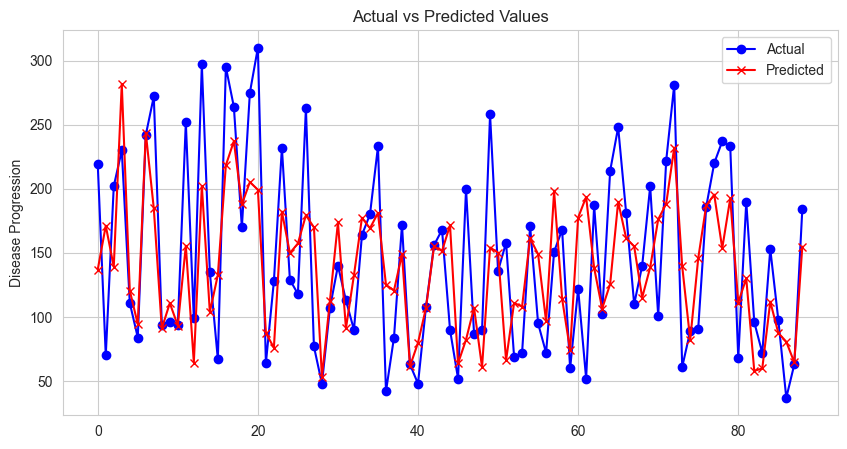

In [53]:
# actual vs predicted
plt.figure(figsize=(10, 5))

plt.plot(y_test.values, label="Actual", marker="o", color="blue")
plt.plot(y_test_pred, label="Predicted", marker="x", color="red")

plt.title("Actual vs Predicted Values")
plt.ylabel("Disease Progression")
plt.legend()
plt.show()

# End of Documents